In [3]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import sklearn

import typing

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.impute import SimpleImputer

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

random_state = 123

# Load and prepare data

In [5]:
df = pd.read_csv("universities.csv")

df_train, df_test = train_test_split(df, test_size=0.2, random_state=random_state)

target_column = "Rank"
X = df_train.drop(columns=[target_column, "Overall Score", "Name", "Year", "Country"])
y = df_train[target_column]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)  

X_train.isna().sum()/X_train.shape[0]

X_test = df_test.drop(columns=[target_column, "Overall Score", "Name", "Year", "Country"])
y_test = df_test[target_column] 

## Encoding Continent column

In [7]:
enc = OneHotEncoder(drop="if_binary", sparse_output=False, handle_unknown="ignore")
encoded_X_train = enc.fit_transform(X_train[["Continent"]])
col_names = enc.get_feature_names_out(input_features=["Continent"])

encoded_X_train = pd.DataFrame(encoded_X_train, columns=col_names, index=X_train.index)
X_train = pd.concat([X_train.drop(columns=["Continent"]), encoded_X_train], axis=1)

encoded_X_valid = enc.transform(X_valid[["Continent"]])
encoded_X_valid = pd.DataFrame(encoded_X_valid, columns=col_names, index=X_valid.index)
X_valid = pd.concat([X_valid.drop(columns=["Continent"]), encoded_X_valid], axis=1)

encoded_X_test = enc.transform(X_test[["Continent"]])
encoded_X_test = pd.DataFrame(encoded_X_test, columns=col_names, index=X_test.index)
X_test = pd.concat([X_test.drop(columns=["Continent"]), encoded_X_test], axis=1)

In [8]:
imputer = SimpleImputer(strategy="mean")
X_train[["Female to Male Ratio", "Population", "CO2", "Corruption", "GDP", "HDI", "GII"]] = imputer.fit_transform(X_train[["Female to Male Ratio", "Population", "CO2", "Corruption", "GDP", "HDI", "GII"]])
X_valid[["Female to Male Ratio", "Population", "CO2", "Corruption", "GDP", "HDI", "GII"]] = imputer.transform(X_valid[["Female to Male Ratio", "Population", "CO2", "Corruption", "GDP", "HDI", "GII"]])
X_test[["Female to Male Ratio", "Population", "CO2", "Corruption", "GDP", "HDI", "GII"]] = imputer.transform(X_test[["Female to Male Ratio", "Population", "CO2", "Corruption", "GDP", "HDI", "GII"]])
X_train.isna().sum()/X_train.shape[0]

Student Population         0.0
Students to Staff Ratio    0.0
International Students     0.0
Female to Male Ratio       0.0
Teaching                   0.0
Research Environment       0.0
Research Quality           0.0
Industry Impact            0.0
International Outlook      0.0
Population                 0.0
CO2                        0.0
Corruption                 0.0
GDP                        0.0
HDI                        0.0
GII                        0.0
Continent_Africa           0.0
Continent_America          0.0
Continent_Asia             0.0
Continent_Europe           0.0
Continent_Oceania          0.0
dtype: float64

# Train Models

In [23]:
def grid_search(regressor, param_grid, X_train, y_train, X_valid, y_valid, cv: int = 5):
    scoring = {
        'R2': make_scorer(r2_score),
        'RMSE': make_scorer(root_mean_squared_error)
    }
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', regressor)
    ])
    
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scoring,
        refit='R2',
        cv=cv,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    train_r2 = r2_score(y_train, best_model.predict(X_train))
    train_rmse = root_mean_squared_error(y_train, best_model.predict(X_train))
    valid_r2 = r2_score(y_valid, best_model.predict(X_valid))
    valid_rmse = root_mean_squared_error(y_valid, best_model.predict(X_valid))
    
    results = {
        'train_r2': train_r2,
        'train_rmse': train_rmse,
        'valid_r2': valid_r2,
        'valid_rmse': valid_rmse
    }
    
    return best_model, best_params, results


In [25]:
def show_coefs(model, X, model_name):
    coefficients = model.coef_

    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': coefficients
    })
    
    feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
    feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)
    
    print(feature_importance[['Feature', 'Coefficient']])
    
    top_features = feature_importance.head(10)
    
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'], top_features['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title(f'Top 10 Features Contributing to {model_name} Regression')
    plt.gca().invert_yaxis()
    plt.savefig(f"results/{model_name}_coefs")
    plt.show()

In [27]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    test_r2 = r2_score(y_test, y_pred)
    test_rmse = root_mean_squared_error(y_test, y_pred)

    print(f"Test R^2: {test_r2:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")

    residuals = y_test - y_pred
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.title("Residual Plot")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title("Parity Plot")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.grid()

    plt.tight_layout()
    plt.savefig(f"results/{model_name}_eval")
    plt.show()

## Lasso

In [30]:
lasso_params = {
    'regressor__alpha': [0.1, 1, 10],
    'regressor__max_iter': [1000, 5000]
}
lasso = Lasso(random_state=42)

best_model_lasso, best_params_lasso, results_lasso = grid_search(
    regressor=lasso,
    param_grid=lasso_params,
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid
)

print("Best Parameters:", best_params_lasso)
print("Metrics:", results_lasso)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'regressor__alpha': 0.1, 'regressor__max_iter': 1000}
Metrics: {'train_r2': 0.7676074269613562, 'train_rmse': 240.81370559022452, 'valid_r2': 0.7688857773609957, 'valid_rmse': 244.7139911426284}


                    Feature  Coefficient
6          Research Quality  -283.004845
7           Industry Impact   -85.944396
4                  Teaching   -66.975873
13                      HDI    50.981069
11               Corruption   -44.658955
5      Research Environment   -38.930256
10                      CO2   -37.773538
2    International Students   -33.401547
12                      GDP    25.881711
15         Continent_Africa    22.489076
17           Continent_Asia    21.345133
18         Continent_Europe   -19.788582
0        Student Population   -12.654822
9                Population   -12.060920
8     International Outlook   -10.260566
19        Continent_Oceania    -5.033898
14                      GII    -4.789328
3      Female to Male Ratio     4.557278
1   Students to Staff Ratio     3.129516
16        Continent_America     0.000000


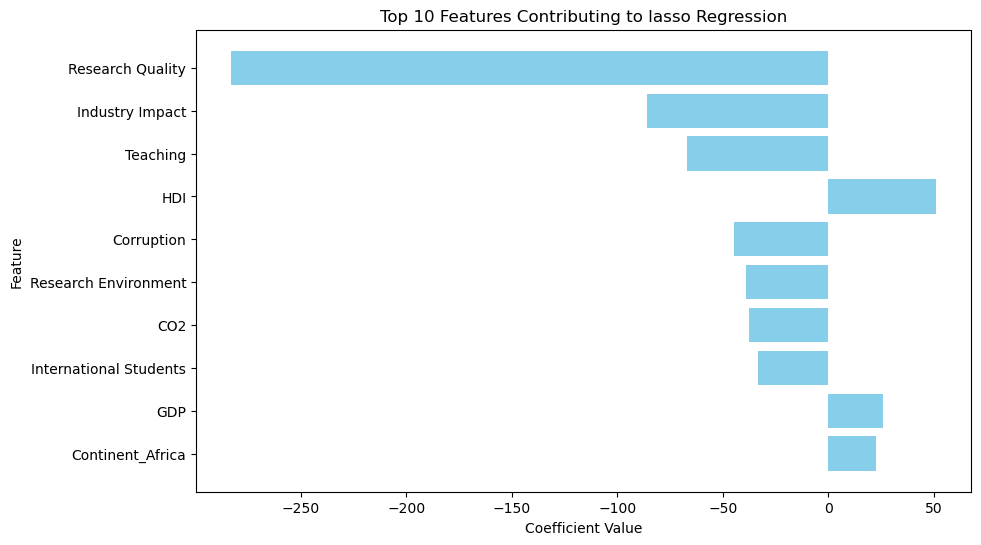

C:\Users\kilia\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


Test R^2: -157258005368101299814400.0000
Test RMSE: 199482899047744.6875


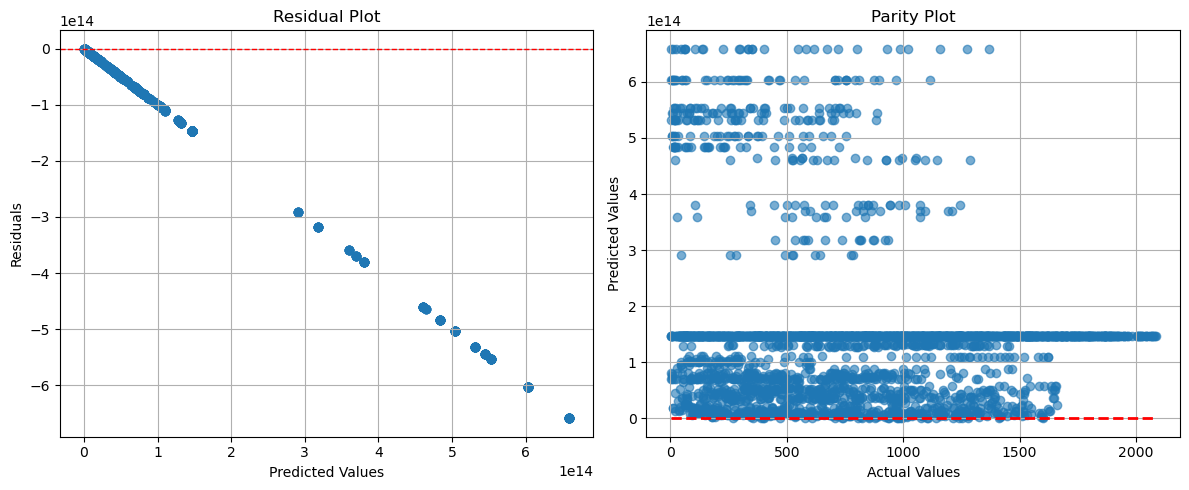

In [31]:
lasso_model = best_model_lasso.named_steps['regressor']

show_coefs(lasso_model, X_train, "lasso")
evaluate_model(lasso_model, X_test, y_test, "lasso")

## Ridge

In [33]:
ridge_params = {
    'regressor__alpha': [0.1, 1, 10, 100],
    'regressor__max_iter': [1000, 5000]
}
ridge = Ridge(random_state=random_state)

best_model_ridge, best_params_ridge, results_ridge = grid_search(
    regressor=ridge,
    param_grid=ridge_params,
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid
)

print("Ridge Regression Results:")
print("Best Parameters:", best_params_ridge)
print("Metrics:", results_ridge)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Ridge Regression Results:
Best Parameters: {'regressor__alpha': 10, 'regressor__max_iter': 1000}
Metrics: {'train_r2': 0.7676078639084727, 'train_rmse': 240.81347919980604, 'valid_r2': 0.7688409234409863, 'valid_rmse': 244.73773665068248}


                    Feature  Coefficient
6          Research Quality  -282.458809
7           Industry Impact   -85.903225
4                  Teaching   -66.795701
13                      HDI    50.442990
11               Corruption   -44.843026
5      Research Environment   -39.299511
10                      CO2   -38.029188
2    International Students   -33.148185
12                      GDP    26.179795
18         Continent_Europe   -23.177150
15         Continent_Africa    21.202446
17           Continent_Asia    18.281794
0        Student Population   -13.060415
9                Population   -12.498424
8     International Outlook   -10.657411
19        Continent_Oceania    -6.238082
14                      GII    -5.492182
3      Female to Male Ratio     4.678934
1   Students to Staff Ratio     3.540942
16        Continent_America    -2.594486


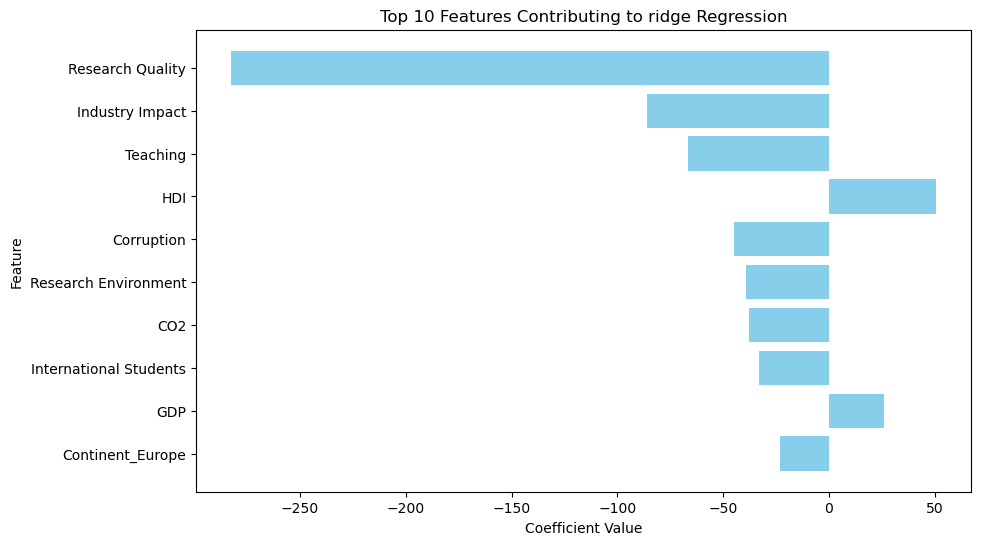

C:\Users\kilia\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


Test R^2: -160901082996395359600640.0000
Test RMSE: 201780304612305.8438


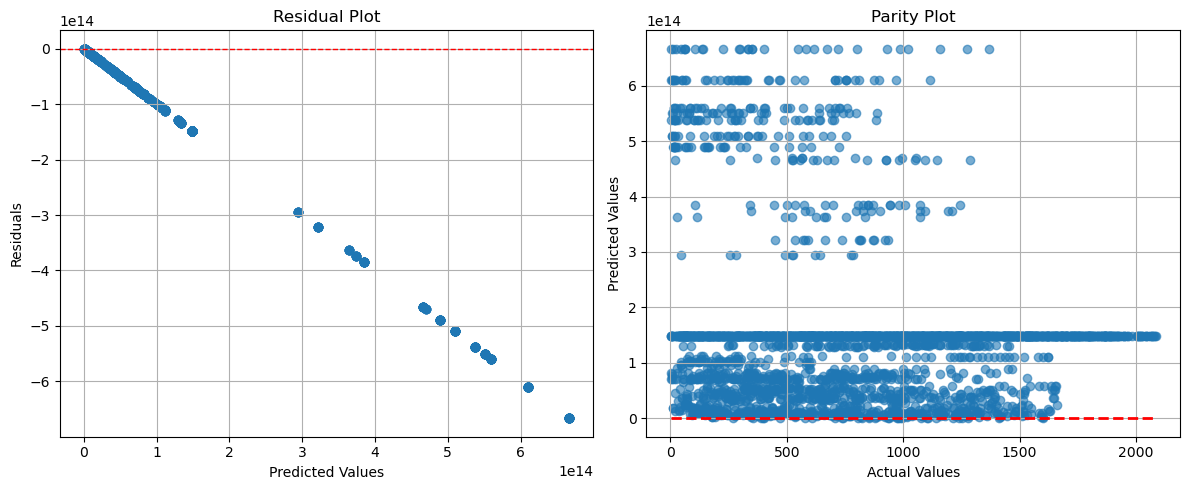

In [34]:
ridge_model = best_model_ridge.named_steps['regressor']

show_coefs(ridge_model, X_train, "ridge")
evaluate_model(ridge_model, X_test, y_test, "ridge")

## GradientBoostingRegressor

In [36]:
gbr_params = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7]
}
gbr = GradientBoostingRegressor(random_state=random_state)

best_model_gbr, best_params_gbr, results_gbr = grid_search(
    regressor=gbr,
    param_grid=gbr_params,
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid
)

print("Best Parameters:", best_params_gbr)
print("Metrics:", results_gbr)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 7, 'regressor__n_estimators': 200}
Metrics: {'train_r2': 0.9975633151324771, 'train_rmse': 24.65867640753987, 'valid_r2': 0.9855132772461765, 'valid_rmse': 61.267553438770136}


Test R^2: 0.9850
Test RMSE: 61.5594


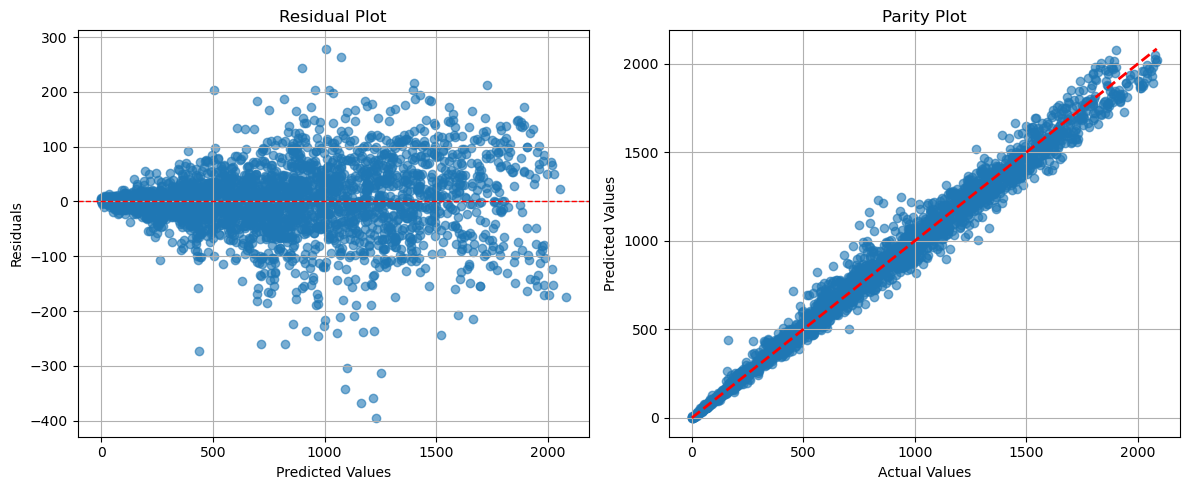

In [37]:
evaluate_model(best_model_gbr, X_test, y_test, "GradientBoostingRegressor")